# Comparison of "No Splitting" and "Random Splitting" in supervised-wise FF settings

FF-based learning required both positive data and negative data. To use the dataset for both purposes, each FF-based layer was divided into two halves and the MNIST datasets were split into two sets (A, B). Set A contained five randomly selected digits, and set B contained the rest. The first half layer took set A as positive data, and set B as negative. The second half took set B as positive data, and set A as positive. Two different digit splittings are possible for unsupervised-wise FF: "random splitting" and "same splitting", and an additional "no splitting" can be used for supervised-wise FF.

The random splitting made sure each layer received different sets of positives and negatives, while the same splitting made sure each layer receives the same sets. The no splitting simply didn't split, and use all digits for both positives and negatives, only that this mode is only for supervised-wise FF where the negatives use wrong labels.

10 rounds of experiments were done on Random Splitting to assess its deviation. 

The goodness head and four softmax accuracies were used for evaluations. 

For more explanations and discussions, refer to this article.

# 1. Imports

In [1]:
import sys
sys.path.append('../../ffobjects/')

import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from data import create_mnist_datasets
from utils import set_seed, plot_training_curves, get_routes
from trainmgr import TrainMgr
from ffobjects import FFPreNorm, FFSoftmax, FFOverlay, FFGoodness, FFRoutedDense

# CONFIGURATION
NUM_CLASS = 10 # Only digits 0 to 4 are positive samples
IMG_SHAPE = (28, 28, )

# 2. Testbed setup

In [2]:
def create_layers_and_train_seq(units, is_supervised_ff, seed, 
                                route_seed, route_split_mode):
    set_seed(seed=seed)
    
    embedding = tf.reshape(
        tf.one_hot(tf.range(NUM_CLASS), tf.reduce_prod(IMG_SHAPE)), 
        (NUM_CLASS, *IMG_SHAPE))
    
    layers = dict(
        # Utilities
        input = tf.keras.layers.InputLayer(name='input'),
        concat = tf.keras.layers.Concatenate(name='concat'),
        flatten = tf.keras.layers.Flatten(name='flatten'),
        preNorm = FFPreNorm(name='preNorm'),
        overlay = FFOverlay(embedding, name='overlay'),

        # FF layers
        b1 = FFRoutedDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b1'),
        b2 = FFRoutedDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b2'),
        b3 = FFRoutedDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b3'),
        b4 = FFRoutedDense(units=units, optimizer=Adam(0.0001), th_pos=.1, th_neg=.1, name=f'b4'),

        # Classifiers
        softmax    = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax'),
        goodness   = FFGoodness(name=f'goodness'),
        softmax_b1 = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax_b1'),
        softmax_b2 = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax_b2'),
        softmax_b3 = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax_b3'),
        softmax_b4 = FFSoftmax(units=NUM_CLASS, optimizer=Adam(0.001), name=f'softmax_b4'),
    )
    
    ff_layer_names = ['b1', 'b2', 'b3', 'b4']
    routes = get_routes(NUM_CLASS, units, len(ff_layer_names), route_seed, route_split_mode)
    for name, route in zip(ff_layer_names, routes):
        if is_supervised_ff:
            layers[name].ff_set_ctu_map(route, route)
        else:
            layers[name].ff_set_ctu_map(route, 1 - route)
    
    def train_seq(X, y, y_ff):
        x = layers['input'](X)
        if is_supervised_ff:
            x = layers['overlay'].ff_do_task((x, y), None)
        x = layers['flatten'](x)
        b1a = layers['b1'].ff_set_classes(y).ff_do_task(x, y_ff)
        b1n = layers['preNorm'](b1a)
        b2a = layers['b2'].ff_set_classes(y).ff_do_task(b1n, y_ff)
        b2n = layers['preNorm'](b2a)
        b3a = layers['b3'].ff_set_classes(y).ff_do_task(b2n, y_ff)
        b3n = layers['preNorm'](b3a)
        b4a = layers['b4'].ff_set_classes(y).ff_do_task(b3n, y_ff)
        b4n = layers['preNorm'](b4a)
        if is_supervised_ff:
            goodness_x = layers['concat']([b2a, b3a, b4a])
            y_pred = layers['goodness'].ff_do_task(goodness_x, y)
        else:
            softmax_x = layers['concat']([b2n, b3n, b4n])
            y_pred = layers['softmax'].ff_do_task(softmax_x, y)
            
        _ = layers['softmax_b1'].ff_do_task(b1n, y)
        _ = layers['softmax_b2'].ff_do_task(b2n, y)
        _ = layers['softmax_b3'].ff_do_task(b3n, y)
        _ = layers['softmax_b4'].ff_do_task(b4n, y)
        return y_pred
    
    return layers, train_seq

def train_layers(
    units, is_supervised_ff, 
    batch_size, data_shuffle_seed, 
    trainable_layers_list, show_metrics_max,
    route_seed, route_split_mode,
):
    '''
    Refer to the example in the next cell for explanation of arguments.
    '''
    layers, train_seq = create_layers_and_train_seq(
        units=units, 
        seed=300, 
        is_supervised_ff=is_supervised_ff,
        route_seed=route_seed,
        route_split_mode=route_split_mode)
    
    set_seed(seed=300)
    dataset = create_mnist_datasets(
        seed=data_shuffle_seed, 
        batch_size=batch_size, 
        is_supervised_ff=is_supervised_ff)
    train_mgr = TrainMgr(layers, train_seq).ff_train(
        dataset, 
        trainable_layers_list, 
        show_metrics_max=show_metrics_max)
    plot_training_curves(train_mgr)
    
    return train_mgr

# 3. Random Splitting - 10 rounds

200/200 [==============================] - 1496s 7s/step - b1: 0.0858 - b2: 0.2880 - b3: 0.2947 - b4: 0.3204 - goodness_duped: 0.9143 - softmax_b1: 0.9892 - softmax_b2: 0.9643 - softmax_b3: 0.9456 - softmax_b4: 0.9429 - best_goodness_duped: 0.9211 - best_softmax_b1: 0.9892 - best_softmax_b2: 0.9787 - best_softmax_b3: 0.9759 - best_softmax_b4: 0.9757


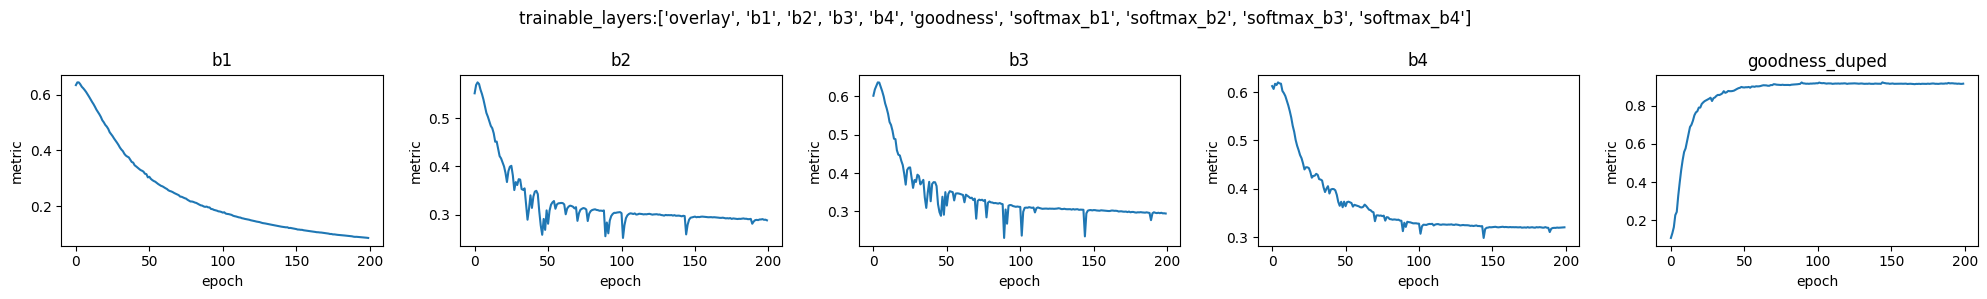

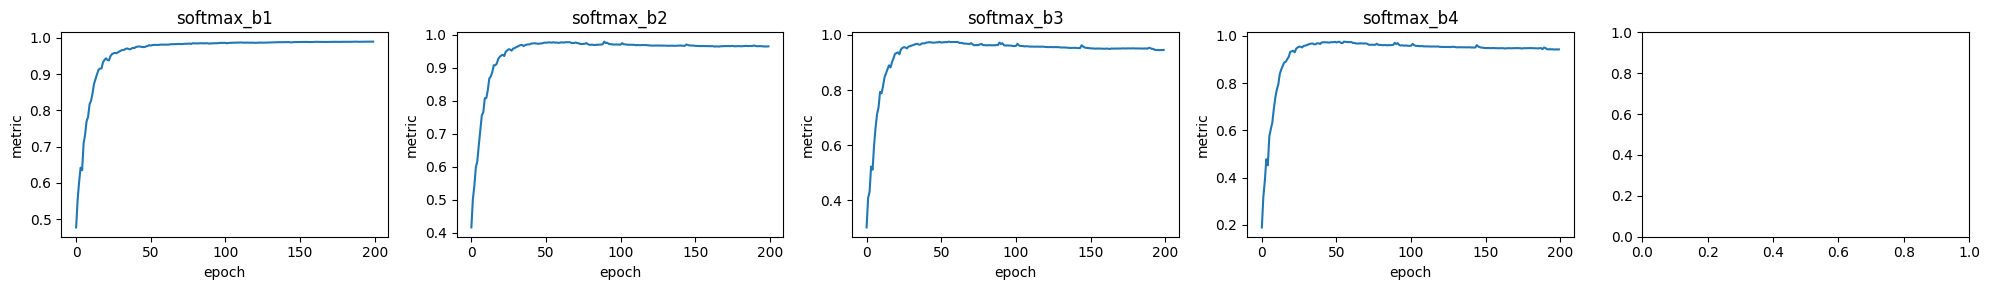

200/200 [==============================] - 1566s 8s/step - b1: 0.0885 - b2: 0.2933 - b3: 0.3594 - b4: 0.3169 - goodness_duped: 0.9145 - softmax_b1: 0.9908 - softmax_b2: 0.9602 - softmax_b3: 0.9400 - softmax_b4: 0.9384 - best_goodness_duped: 0.9180 - best_softmax_b1: 0.9909 - best_softmax_b2: 0.9780 - best_softmax_b3: 0.9765 - best_softmax_b4: 0.9759


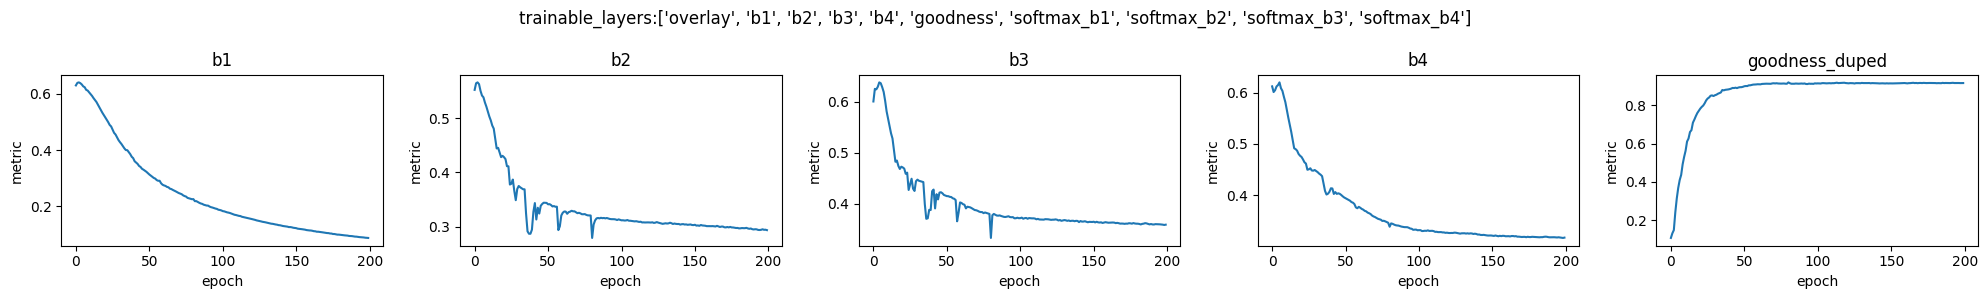

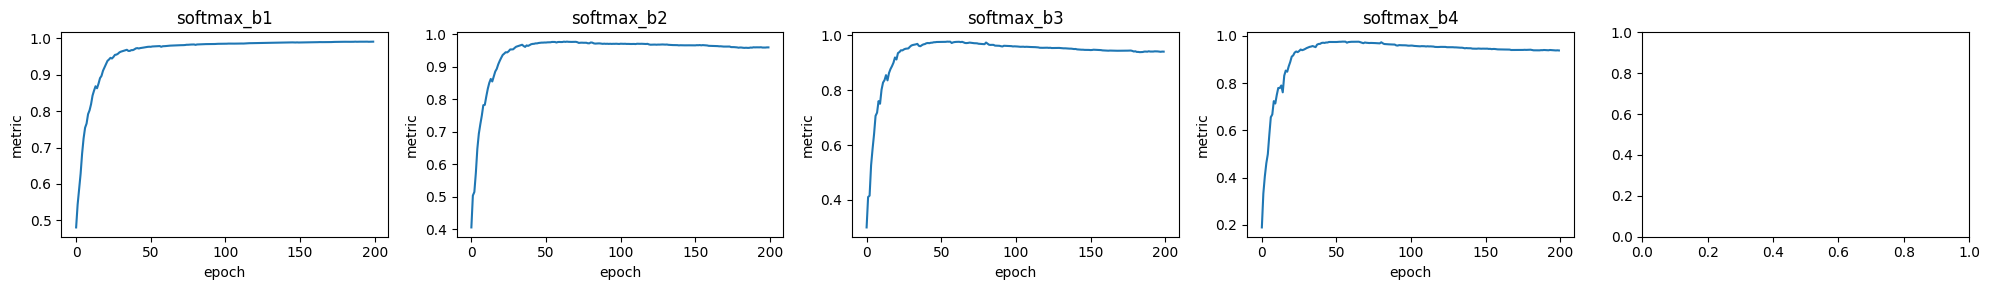

200/200 [==============================] - 1688s 8s/step - b1: 0.0906 - b2: 0.2950 - b3: 0.3615 - b4: 0.3121 - goodness_duped: 0.9146 - softmax_b1: 0.9885 - softmax_b2: 0.9654 - softmax_b3: 0.9339 - softmax_b4: 0.9304 - best_goodness_duped: 0.9150 - best_softmax_b1: 0.9889 - best_softmax_b2: 0.9780 - best_softmax_b3: 0.9766 - best_softmax_b4: 0.9767


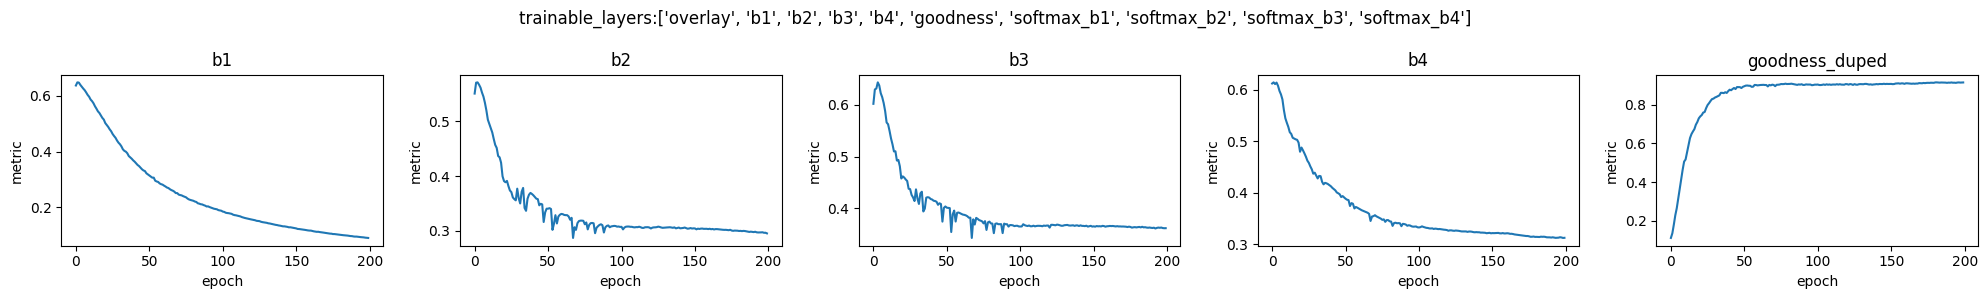

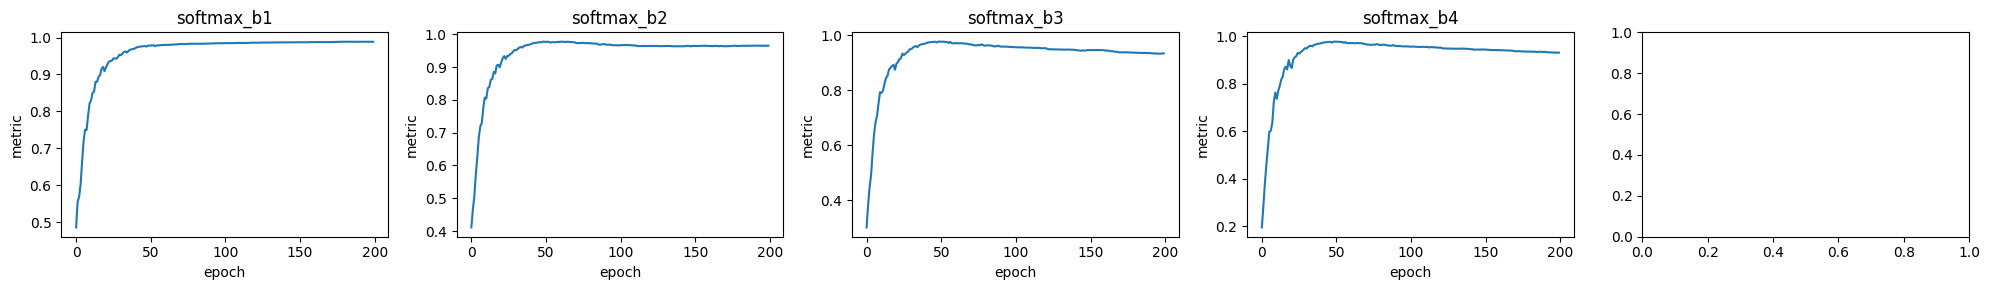

200/200 [==============================] - 1664s 8s/step - b1: 0.0858 - b2: 0.2929 - b3: 0.3535 - b4: 0.3146 - goodness_duped: 0.9200 - softmax_b1: 0.9892 - softmax_b2: 0.9662 - softmax_b3: 0.9413 - softmax_b4: 0.9313 - best_goodness_duped: 0.9252 - best_softmax_b1: 0.9892 - best_softmax_b2: 0.9779 - best_softmax_b3: 0.9765 - best_softmax_b4: 0.9759


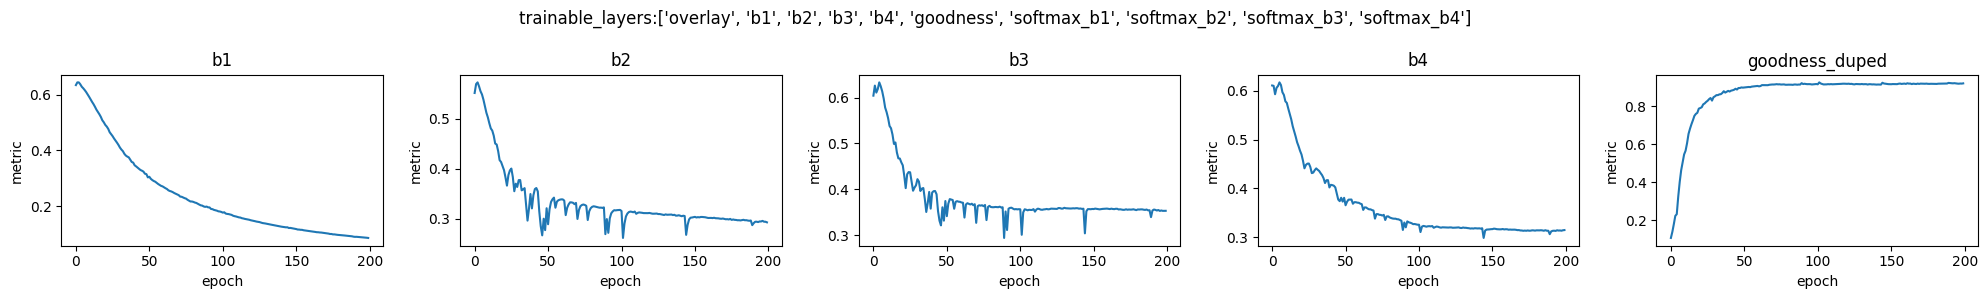

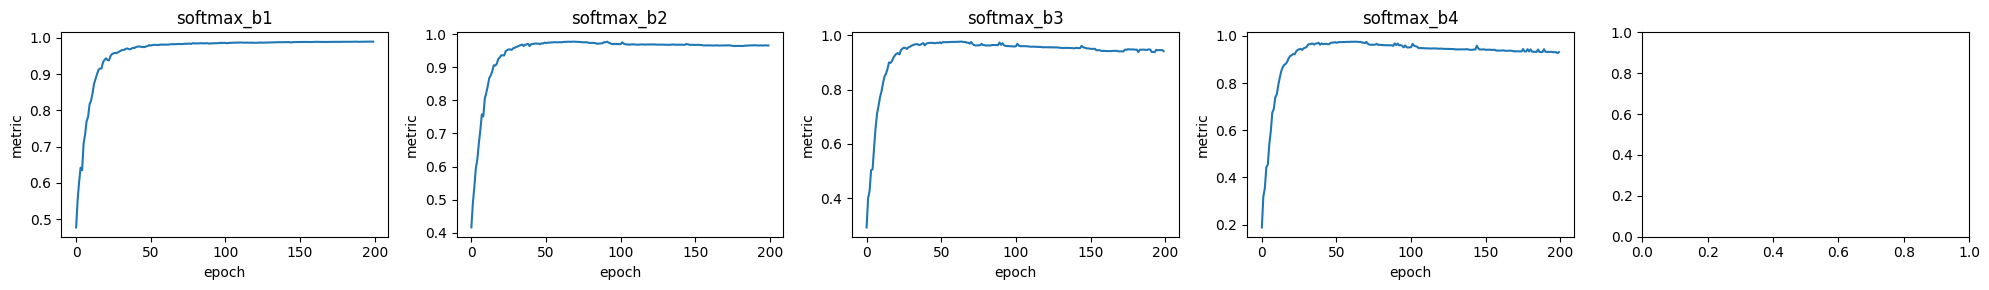

200/200 [==============================] - 1564s 8s/step - b1: 0.0884 - b2: 0.2422 - b3: 0.3634 - b4: 0.3562 - goodness_duped: 0.9157 - softmax_b1: 0.9905 - softmax_b2: 0.9761 - softmax_b3: 0.9329 - softmax_b4: 0.9363 - best_goodness_duped: 0.9164 - best_softmax_b1: 0.9905 - best_softmax_b2: 0.9800 - best_softmax_b3: 0.9775 - best_softmax_b4: 0.9771


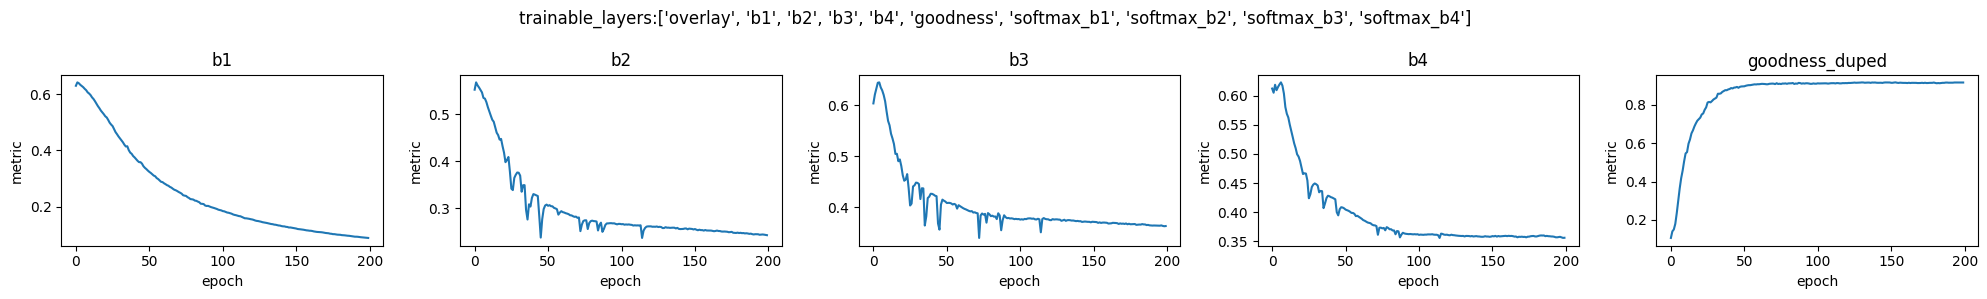

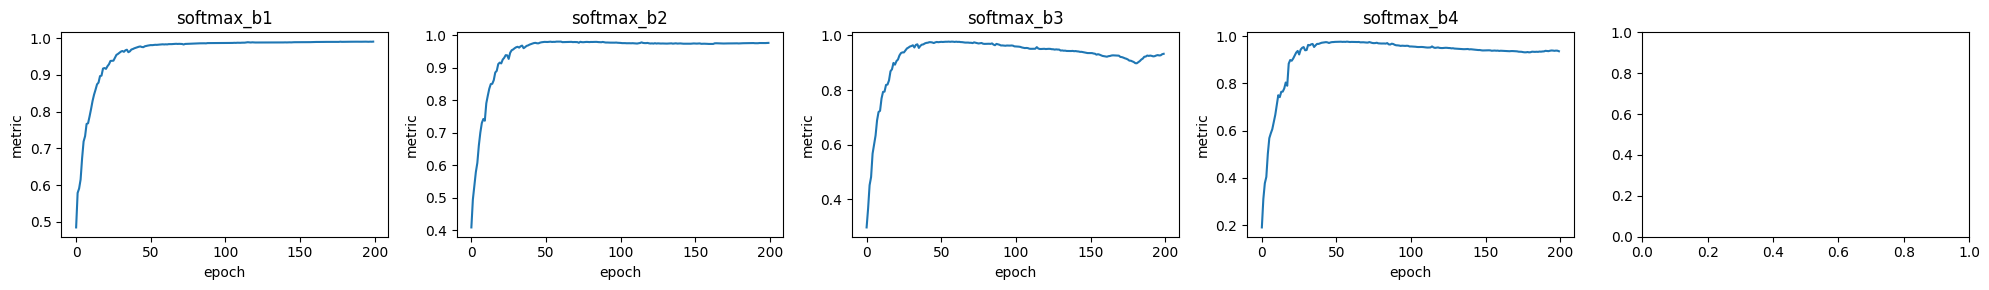

200/200 [==============================] - 1510s 8s/step - b1: 0.0904 - b2: 0.2943 - b3: 0.3622 - b4: 0.3160 - goodness_duped: 0.9142 - softmax_b1: 0.9900 - softmax_b2: 0.9663 - softmax_b3: 0.9455 - softmax_b4: 0.9417 - best_goodness_duped: 0.9142 - best_softmax_b1: 0.9903 - best_softmax_b2: 0.9748 - best_softmax_b3: 0.9726 - best_softmax_b4: 0.9718


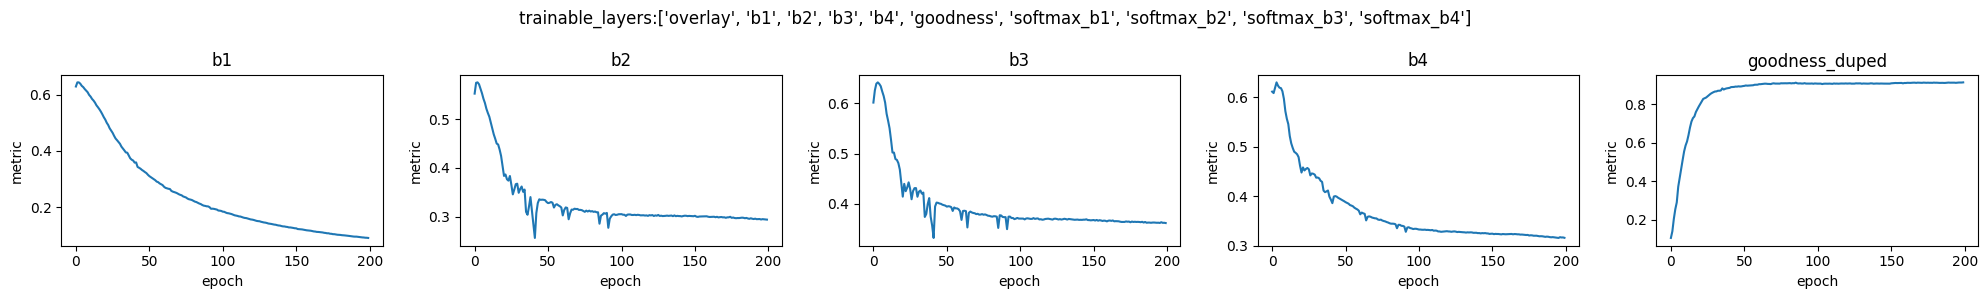

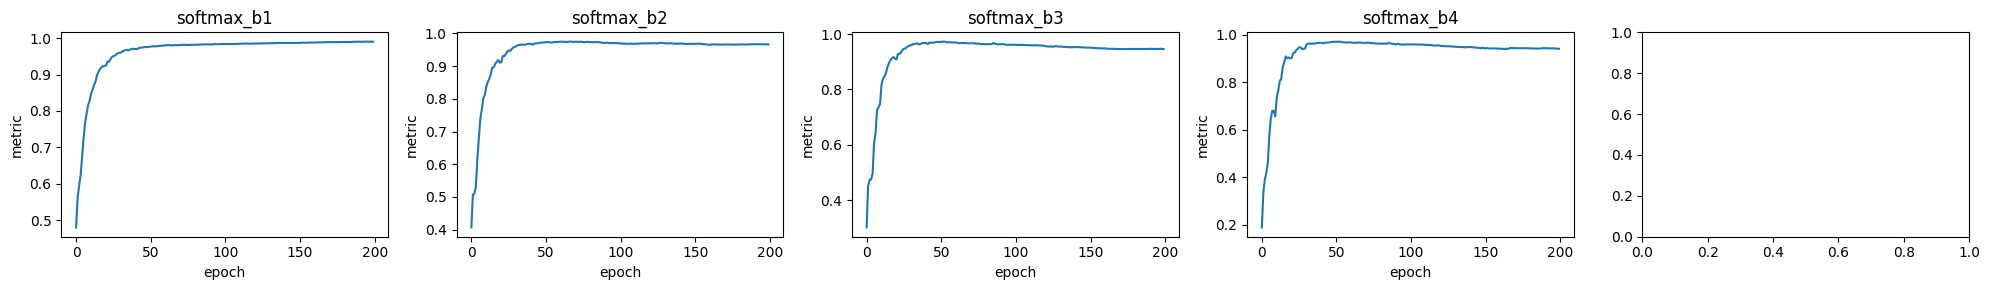

200/200 [==============================] - 1444s 7s/step - b1: 0.0865 - b2: 0.2931 - b3: 0.3502 - b4: 0.3036 - goodness_duped: 0.9114 - softmax_b1: 0.9891 - softmax_b2: 0.9653 - softmax_b3: 0.9425 - softmax_b4: 0.9339 - best_goodness_duped: 0.9188 - best_softmax_b1: 0.9891 - best_softmax_b2: 0.9778 - best_softmax_b3: 0.9762 - best_softmax_b4: 0.9763


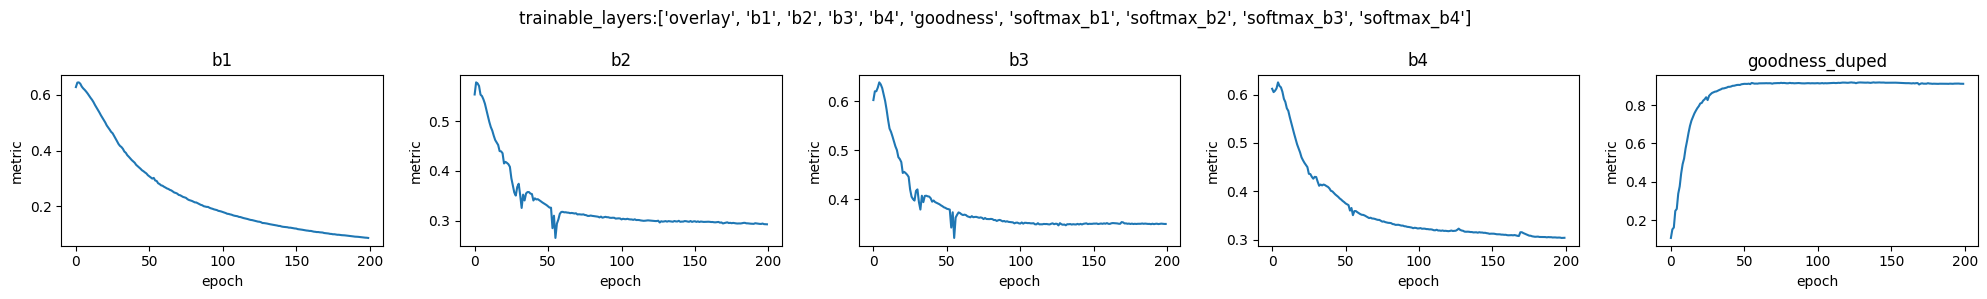

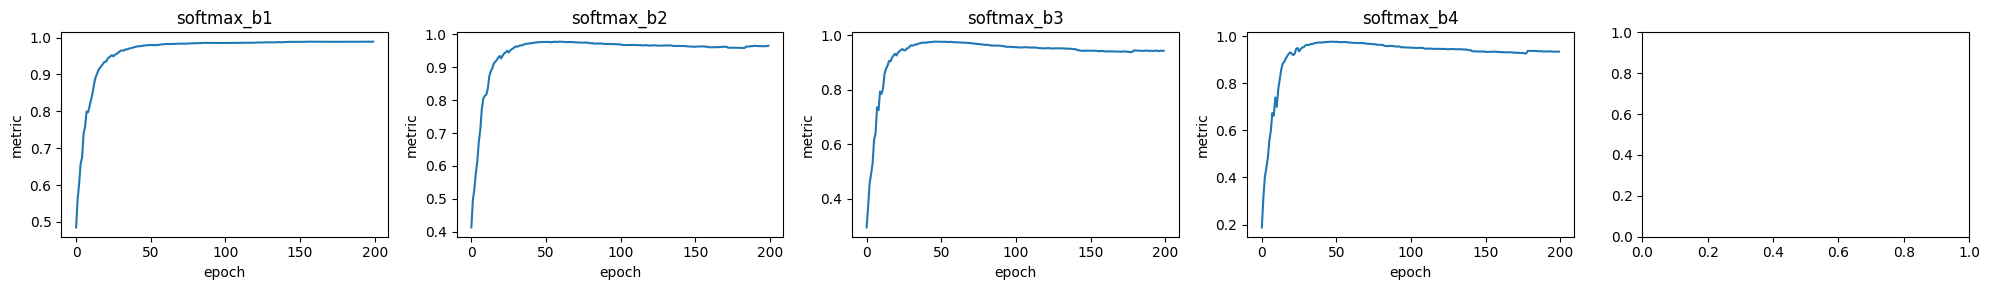

200/200 [==============================] - 1473s 7s/step - b1: 0.0908 - b2: 0.2912 - b3: 0.3032 - b4: 0.3322 - goodness_duped: 0.9170 - softmax_b1: 0.9903 - softmax_b2: 0.9650 - softmax_b3: 0.9414 - softmax_b4: 0.9375 - best_goodness_duped: 0.9197 - best_softmax_b1: 0.9904 - best_softmax_b2: 0.9768 - best_softmax_b3: 0.9759 - best_softmax_b4: 0.9754


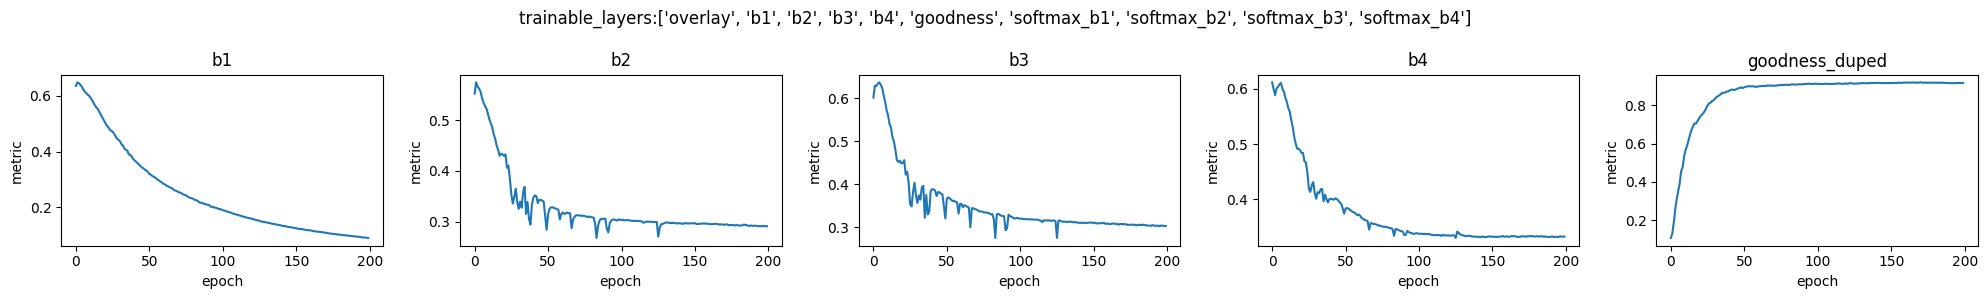

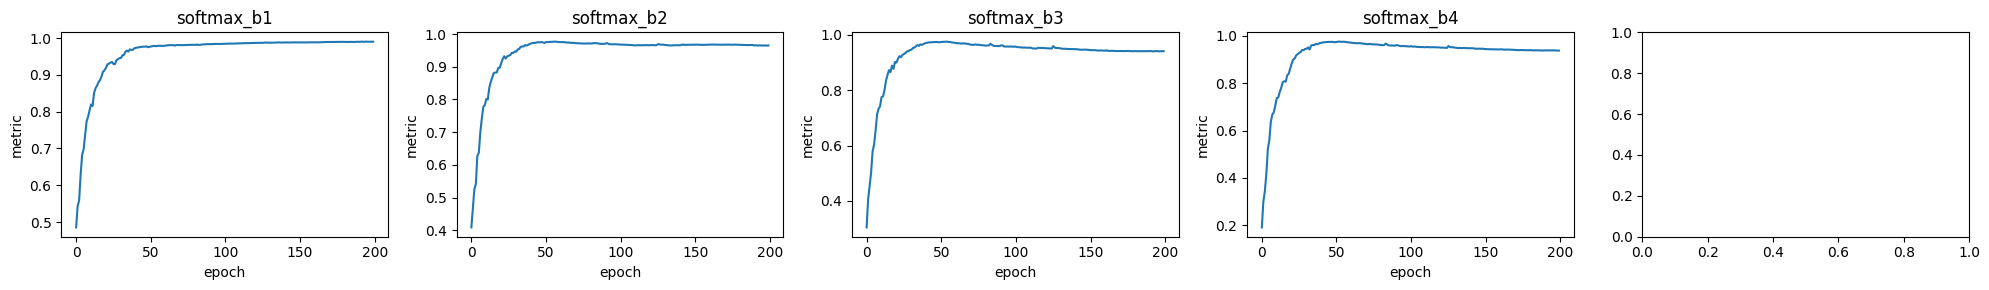

200/200 [==============================] - 1515s 8s/step - b1: 0.0878 - b2: 0.2923 - b3: 0.3572 - b4: 0.3045 - goodness_duped: 0.9005 - softmax_b1: 0.9893 - softmax_b2: 0.9615 - softmax_b3: 0.9371 - softmax_b4: 0.9367 - best_goodness_duped: 0.9095 - best_softmax_b1: 0.9899 - best_softmax_b2: 0.9784 - best_softmax_b3: 0.9771 - best_softmax_b4: 0.9766


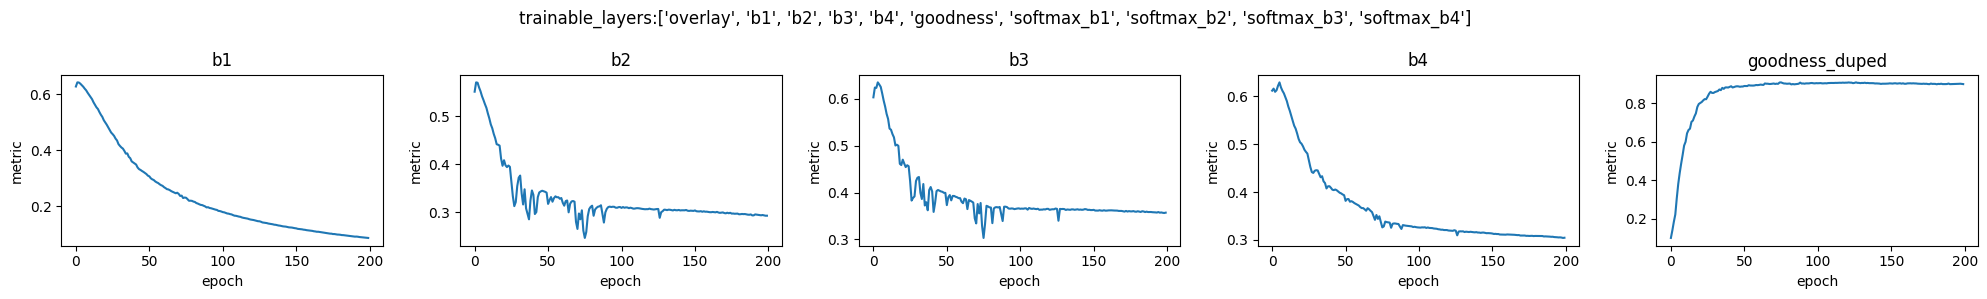

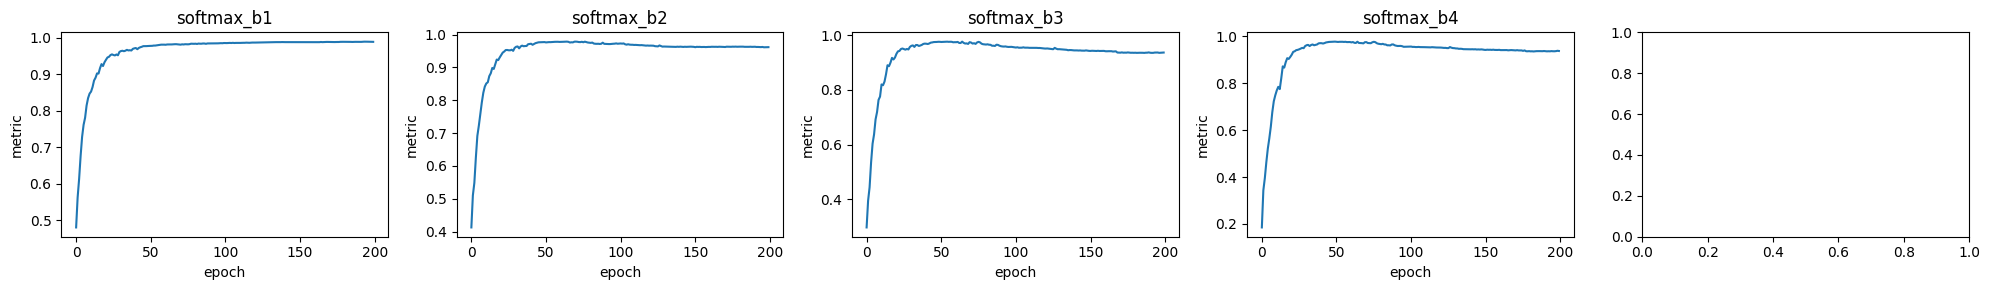

200/200 [==============================] - 1606s 8s/step - b1: 0.0908 - b2: 0.2954 - b3: 0.3641 - b4: 0.2568 - goodness_duped: 0.9050 - softmax_b1: 0.9895 - softmax_b2: 0.9682 - softmax_b3: 0.9520 - softmax_b4: 0.9463 - best_goodness_duped: 0.9092 - best_softmax_b1: 0.9895 - best_softmax_b2: 0.9775 - best_softmax_b3: 0.9756 - best_softmax_b4: 0.9759


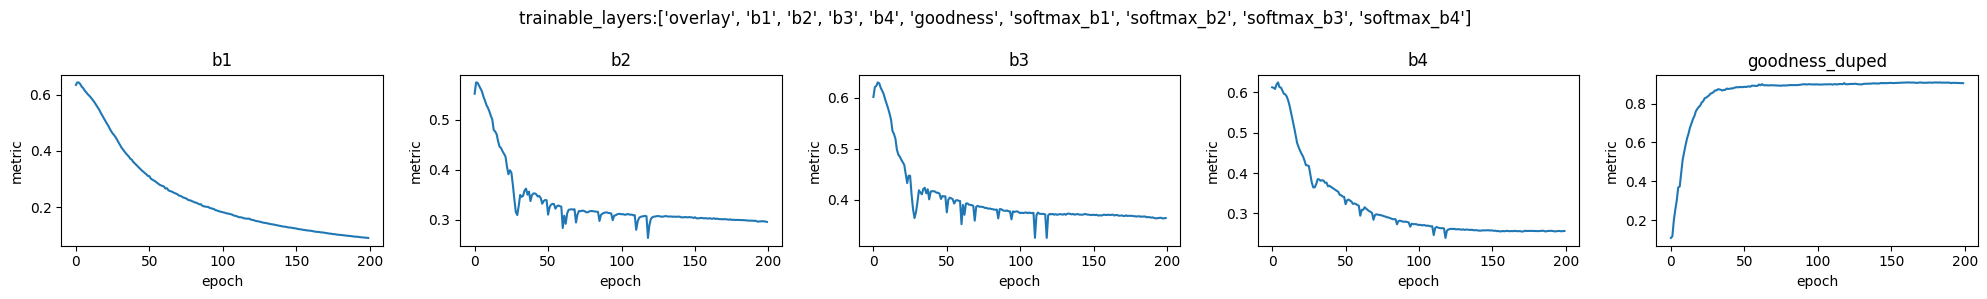

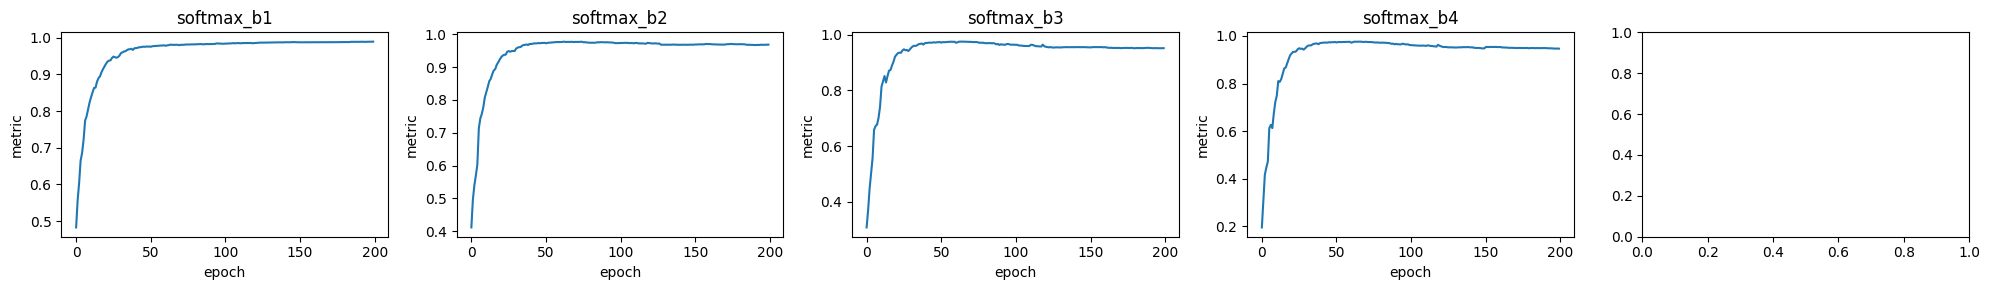

In [3]:
for i in range(10):
    train_mgr0 = train_layers(
        units = 200, #CHANGE
        is_supervised_ff = True, 
        batch_size = 256,
        data_shuffle_seed = 10,
        trainable_layers_list = [
            [['overlay', 'b1', 'b2', 'b3', 'b4', 'goodness', 
              'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4', 
             ], 200],
        ],
        show_metrics_max = ['goodness', 'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4'],
        route_seed = i,
        route_split_mode = 'RandomSplitting',
    )

# 4. No Splitting

200/200 [==============================] - 1318s 7s/step - b1: 0.1214 - b2: 0.1627 - b3: 0.1819 - b4: 0.1741 - goodness_duped: 0.9316 - softmax_b1: 0.9891 - softmax_b2: 0.9830 - softmax_b3: 0.9746 - softmax_b4: 0.9743 - best_goodness_duped: 0.9325 - best_softmax_b1: 0.9891 - best_softmax_b2: 0.9832 - best_softmax_b3: 0.9789 - best_softmax_b4: 0.9794


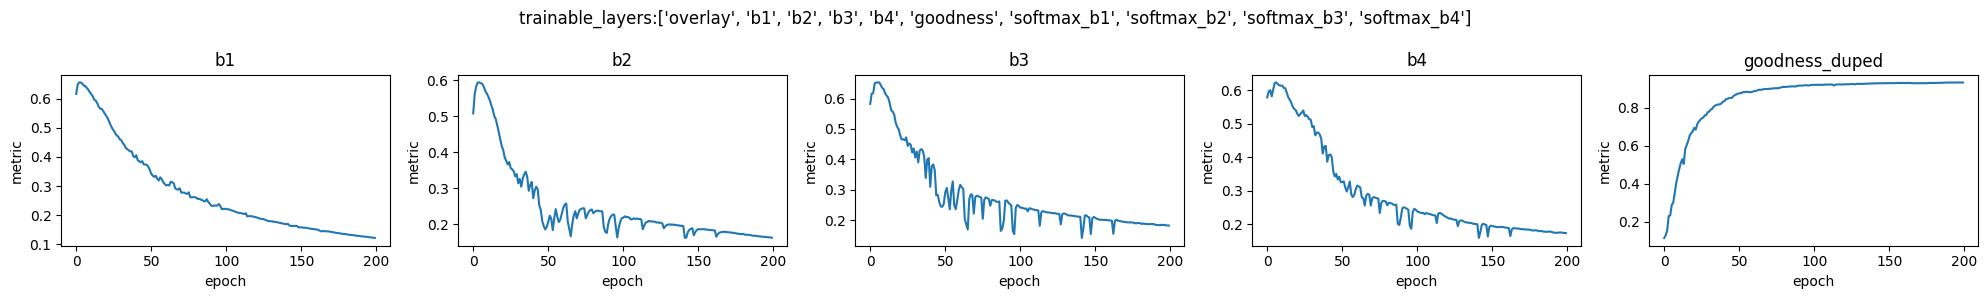

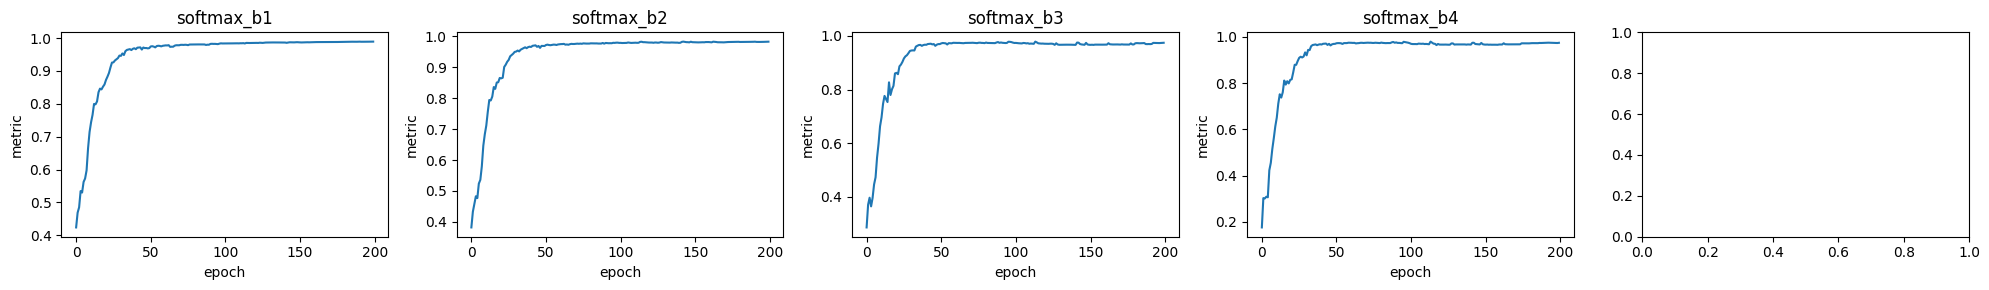

In [4]:
train_mgr0 = train_layers(
    units = 200, #CHANGE
    is_supervised_ff = True, 
    batch_size = 256,
    data_shuffle_seed = 10,
    trainable_layers_list = [
        [['overlay', 'b1', 'b2', 'b3', 'b4', 'goodness', 
          'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4', 
         ], 200],
    ],
    show_metrics_max = ['goodness', 'softmax_b1', 'softmax_b2', 'softmax_b3', 'softmax_b4'],
    route_seed = 0,
    route_split_mode = 'NoSplitting',
)

# 5. generate graphs

In [5]:
results = '''200/200 [==============================] - 1318s 7s/step - b1: 0.1214 - b2: 0.1627 - b3: 0.1819 - b4: 0.1741 - goodness_duped: 0.9316 - softmax_b1: 0.9891 - softmax_b2: 0.9830 - softmax_b3: 0.9746 - softmax_b4: 0.9743 - best_goodness_duped: 0.9325 - best_softmax_b1: 0.9891 - best_softmax_b2: 0.9832 - best_softmax_b3: 0.9789 - best_softmax_b4: 0.9794
200/200 [==============================] - 1496s 7s/step - b1: 0.0858 - b2: 0.2880 - b3: 0.2947 - b4: 0.3204 - goodness_duped: 0.9143 - softmax_b1: 0.9892 - softmax_b2: 0.9643 - softmax_b3: 0.9456 - softmax_b4: 0.9429 - best_goodness_duped: 0.9211 - best_softmax_b1: 0.9892 - best_softmax_b2: 0.9787 - best_softmax_b3: 0.9759 - best_softmax_b4: 0.9757
200/200 [==============================] - 1566s 8s/step - b1: 0.0885 - b2: 0.2933 - b3: 0.3594 - b4: 0.3169 - goodness_duped: 0.9145 - softmax_b1: 0.9908 - softmax_b2: 0.9602 - softmax_b3: 0.9400 - softmax_b4: 0.9384 - best_goodness_duped: 0.9180 - best_softmax_b1: 0.9909 - best_softmax_b2: 0.9780 - best_softmax_b3: 0.9765 - best_softmax_b4: 0.9759
200/200 [==============================] - 1688s 8s/step - b1: 0.0906 - b2: 0.2950 - b3: 0.3615 - b4: 0.3121 - goodness_duped: 0.9146 - softmax_b1: 0.9885 - softmax_b2: 0.9654 - softmax_b3: 0.9339 - softmax_b4: 0.9304 - best_goodness_duped: 0.9150 - best_softmax_b1: 0.9889 - best_softmax_b2: 0.9780 - best_softmax_b3: 0.9766 - best_softmax_b4: 0.9767
200/200 [==============================] - 1664s 8s/step - b1: 0.0858 - b2: 0.2929 - b3: 0.3535 - b4: 0.3146 - goodness_duped: 0.9200 - softmax_b1: 0.9892 - softmax_b2: 0.9662 - softmax_b3: 0.9413 - softmax_b4: 0.9313 - best_goodness_duped: 0.9252 - best_softmax_b1: 0.9892 - best_softmax_b2: 0.9779 - best_softmax_b3: 0.9765 - best_softmax_b4: 0.9759
200/200 [==============================] - 1564s 8s/step - b1: 0.0884 - b2: 0.2422 - b3: 0.3634 - b4: 0.3562 - goodness_duped: 0.9157 - softmax_b1: 0.9905 - softmax_b2: 0.9761 - softmax_b3: 0.9329 - softmax_b4: 0.9363 - best_goodness_duped: 0.9164 - best_softmax_b1: 0.9905 - best_softmax_b2: 0.9800 - best_softmax_b3: 0.9775 - best_softmax_b4: 0.9771
200/200 [==============================] - 1510s 8s/step - b1: 0.0904 - b2: 0.2943 - b3: 0.3622 - b4: 0.3160 - goodness_duped: 0.9142 - softmax_b1: 0.9900 - softmax_b2: 0.9663 - softmax_b3: 0.9455 - softmax_b4: 0.9417 - best_goodness_duped: 0.9142 - best_softmax_b1: 0.9903 - best_softmax_b2: 0.9748 - best_softmax_b3: 0.9726 - best_softmax_b4: 0.9718
200/200 [==============================] - 1444s 7s/step - b1: 0.0865 - b2: 0.2931 - b3: 0.3502 - b4: 0.3036 - goodness_duped: 0.9114 - softmax_b1: 0.9891 - softmax_b2: 0.9653 - softmax_b3: 0.9425 - softmax_b4: 0.9339 - best_goodness_duped: 0.9188 - best_softmax_b1: 0.9891 - best_softmax_b2: 0.9778 - best_softmax_b3: 0.9762 - best_softmax_b4: 0.9763
200/200 [==============================] - 1473s 7s/step - b1: 0.0908 - b2: 0.2912 - b3: 0.3032 - b4: 0.3322 - goodness_duped: 0.9170 - softmax_b1: 0.9903 - softmax_b2: 0.9650 - softmax_b3: 0.9414 - softmax_b4: 0.9375 - best_goodness_duped: 0.9197 - best_softmax_b1: 0.9904 - best_softmax_b2: 0.9768 - best_softmax_b3: 0.9759 - best_softmax_b4: 0.9754
200/200 [==============================] - 1515s 8s/step - b1: 0.0878 - b2: 0.2923 - b3: 0.3572 - b4: 0.3045 - goodness_duped: 0.9005 - softmax_b1: 0.9893 - softmax_b2: 0.9615 - softmax_b3: 0.9371 - softmax_b4: 0.9367 - best_goodness_duped: 0.9095 - best_softmax_b1: 0.9899 - best_softmax_b2: 0.9784 - best_softmax_b3: 0.9771 - best_softmax_b4: 0.9766
200/200 [==============================] - 1606s 8s/step - b1: 0.0908 - b2: 0.2954 - b3: 0.3641 - b4: 0.2568 - goodness_duped: 0.9050 - softmax_b1: 0.9895 - softmax_b2: 0.9682 - softmax_b3: 0.9520 - softmax_b4: 0.9463 - best_goodness_duped: 0.9092 - best_softmax_b1: 0.9895 - best_softmax_b2: 0.9775 - best_softmax_b3: 0.9756 - best_softmax_b4: 0.9759'''

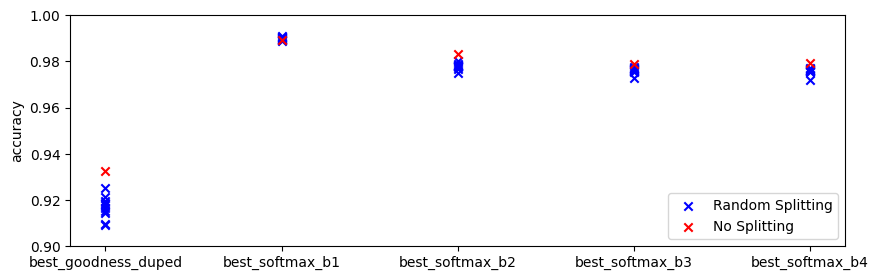

In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
df = pd.DataFrame(
    dict([item.split(': ') for item in l.split(' - ') if ': ' in item])
        for l in results.splitlines() if l
).astype(float)[['best_goodness_duped', 'best_softmax_b1', 'best_softmax_b2', 'best_softmax_b3', 'best_softmax_b4']]

fig, ax = plt.subplots(1, 1, figsize=(10,3))
x = np.tile(np.arange(1, 6), (10,))
y = df.loc[1:].values.flatten()

ax.scatter(x, y, color='blue', marker='x', label='Random Splitting')
ax.scatter(np.arange(1, 6), df.loc[0], color='red', marker='x', label='No Splitting')
ax.set_xticks(ticks=1.0 + np.arange(5), labels=df.columns)
ax.set_ylim(0.9, 1.0)
ax.set_ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()